In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import UQ_toolbox as uq
from PIL import Image
from skimage import io
%matplotlib widget
import matplotlib.pyplot as plt

In [7]:
try:
    num_gpus = torch.cuda.device_count()
    print("Number of GPUs available:", num_gpus)
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
except Exception as e:
    print("Error while checking GPUs:", e)

Number of GPUs available: 3
GPU 0: NVIDIA RTX A6000
GPU 1: NVIDIA RTX A6000
GPU 2: NVIDIA RTX A6000


In [8]:
print(torch.cuda.is_available())
device = torch.device("cuda:1")

True


In [9]:
# Define your CNN model
class simpleNet(nn.Module):
    def __init__(self):
        super(simpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*12*12, 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x= self.dropout_conv(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout_conv(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [10]:
class ToTensor(object):

    def __call__(self, sample):
        image, shape = sample['image'], sample['shape']
        if shape=='Round':
            shape=0
        elif shape=='Irregular':
            shape=1
        elif shape=='Ambiguous':
            shape=2
        return {'image': torch.from_numpy(image).unsqueeze(0),
                'shape': torch.from_numpy(np.asarray(shape))}

In [11]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        image, shape = sample['image'], sample['shape']
        norm = transforms.Normalize(mean=self.mean, std=self.std)
        return {'image': norm(image.float()),
                'shape': shape}

In [12]:
# Load the models
model_paths = ['model_shape_0_augmented.pt', 'model_shape_1_augmented.pt', 'model_shape_2_augmented.pt', 'model_shape_3_augmented.pt', 'model_shape_4_augmented.pt']
models = []

for path in model_paths:
    model = simpleNet()
    model.load_state_dict(torch.load(path))
    model.eval()  # Set the model to evaluation mode
    models.append(model)

In [13]:
class AxialCutsDataset(Dataset):

    def __init__(self, data_shape, transform=None, for_trainning=False, mean=False, std=False, downsample=False):
        self.data = data_shape
        self.transform=transform
        self.for_trainning = for_trainning
        self.mean= mean
        self.std = std
        self.downsample = downsample

        if self.downsample:
            df_majority = self.data[self.data.iloc[:, 1]=='Irregular']
            df_majority_downsampled = resample(df_majority, replace=False, n_samples=1200, random_state=125)
            self.data = pd.concat((self.data[self.data['Shape'] != 'Irregular'], df_majority_downsampled))

    def __len__(self):
        return len(self.data.iloc[:, 0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.data.iloc[idx, 0]
        image = io.imread(img_name)
        shape = self.data.iloc[idx, 1]
        sample = {'image': image, 'shape': shape}

        if self.transform:
            sample = self.transform(sample)

        return sample
        


mean = 87.42158495776914
std = 29.82248099334633

In [14]:
mean = 87.42158495776914
std = 29.82248099334633

In [15]:
images_path = '/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/evaluation_IRM_villes/'
data = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path}*/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path}*/*png')]
        ),
        pd.DataFrame(
            [k.split('/')[-2] for k in glob.glob(f'{images_path}*/*png')]
        ),
    ),
    axis=1,
)
data.columns = ['Path', 'ID', 'Shape']
data.set_index('ID', inplace=True)


axialcuts_dataset_eval = AxialCutsDataset(data_shape=data, downsample=False)
data_without_amb = axialcuts_dataset_eval.data[axialcuts_dataset_eval.data['Shape']!='Ambiguous']
data_amb = axialcuts_dataset_eval.data[axialcuts_dataset_eval.data['Shape']=='Ambiguous']

In [16]:
images_path_tr = '/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/'
data_tr = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path_tr}*/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path_tr}*/*png')]
        ),
        pd.DataFrame(
            [k.split('/')[-2] for k in glob.glob(f'{images_path_tr}*/*png')]
        ),
    ),
    axis=1,
)
data_tr.columns = ['Path', 'ID', 'Shape']
data_tr.set_index('ID', inplace=True)
axialcuts_dataset_tr = AxialCutsDataset(data_shape=data_tr, downsample=False)
data_amb_tr = axialcuts_dataset_tr.data[axialcuts_dataset_tr.data['Shape']=='Ambiguous']

In [17]:
data_transforms = transforms.Compose([
    ToTensor(),
    Normalize(mean=mean, std=std)
])

In [18]:
data_without_amb = AxialCutsDataset(data_shape=data_without_amb, downsample=False, transform=data_transforms)
data_amb = AxialCutsDataset(data_shape=data_amb, downsample=False, transform=data_transforms)
data_amb_tr = AxialCutsDataset(data_shape=data_amb_tr, downsample=False, transform=data_transforms)

In [19]:
eval_data = DataLoader(data_without_amb, num_workers=12)
eval_data_amb = DataLoader(data_amb, num_workers=12)
tr_data_amb = DataLoader(data_amb_tr, num_workers=12)

In [20]:
# Define functions for evaluation metrics
def accuracy(outputs, labels):
    preds = outputs > 0.5 
    return accuracy_score(labels, preds)

def f1(outputs, labels):
    preds = outputs > 0.5
    return f1_score(labels, preds, average='binary')

def calculate_sensitivity(outputs, labels):
    preds = outputs > 0.5
    return recall_score(labels, preds, average='binary')

def roc_auc(outputs, labels):
    probs = outputs
    return roc_auc_score(labels, probs)

def compute_confusion_matrix(outputs, labels):
    preds = outputs > 0.5
    return confusion_matrix(labels, preds)

def calculate_specificity(cm):
    TN = cm[0, 0]  # True negatives
    FP = cm[0, 1]  # False positives
    return TN / (TN + FP)

In [21]:
def display_confusion_matrix(cm):
    # Define class names
    class_names = ['Round', 'Irregular']
    
    # Create a DataFrame for better visualization
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [22]:
def calculate_val_metrics(all_preds, all_labels):

    # Compute evaluation metrics
    acc = accuracy(all_preds, all_labels)
    f1_result = f1(all_preds, all_labels)
    roc_auc_result = roc_auc(all_preds, all_labels)
    cm = compute_confusion_matrix(all_preds, all_labels)
    display_confusion_matrix(cm)
    sensitivity_value = calculate_sensitivity(all_preds, all_labels)
    specificity_value = calculate_specificity(cm)

    print('Accuracy: {:.6f} \tF1 Score: {:.6f} \tROC AUC: {:.6f} \tSpecificity: {:.6f} \tSensitivity: {:.6f}'.format(
        acc, f1_result, roc_auc_result, specificity_value, sensitivity_value))

In [23]:
# Function to make predictions
def predict(models, image):
    image = image.to(device)
    predictions = [model(image).cpu().detach().numpy() for model in models]
    return predictions

In [24]:
# Store results
all_results = []
mean_pred = []
true_labels = []
models = [model.to(device) for model in models]
# Inference
with torch.no_grad():
    for batch in eval_data:
        images = batch['image']
        labels = batch['shape']

        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred.append(np.mean(pred_probs))
        true_labels.append(labels.item())
        all_results.append({
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs),
            'mean': np.mean(pred_probs)
        })

In [25]:
models_pred = [[all_results[k]['predicted_probabilities'][i].ravel() for k in range(len(all_results))] for i in range(5)]
mean_ensembling_pred = [all_results[k]['mean'] for k in range(len(all_results))]

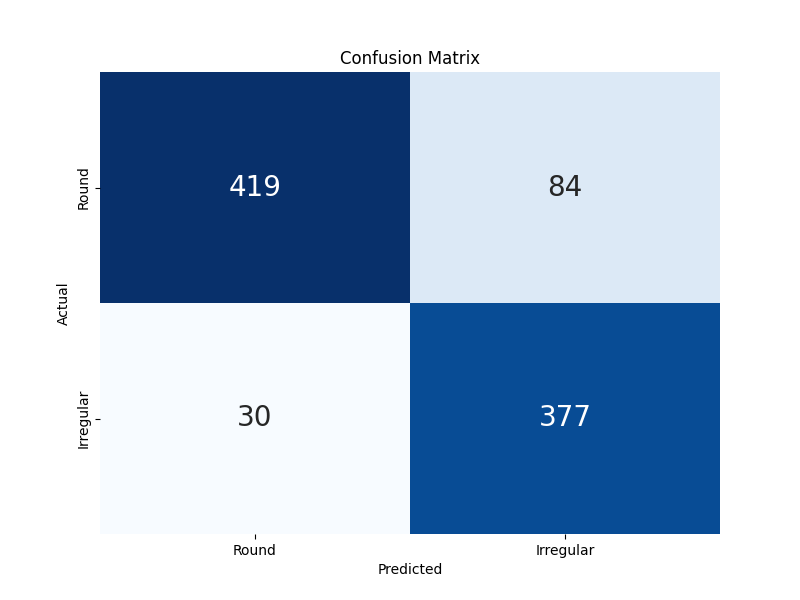

Accuracy: 0.874725 	F1 Score: 0.868664 	ROC AUC: 0.931902 	Specificity: 0.833002 	Sensitivity: 0.926290


In [26]:
calculate_val_metrics(np.array(mean_pred), np.array(true_labels))

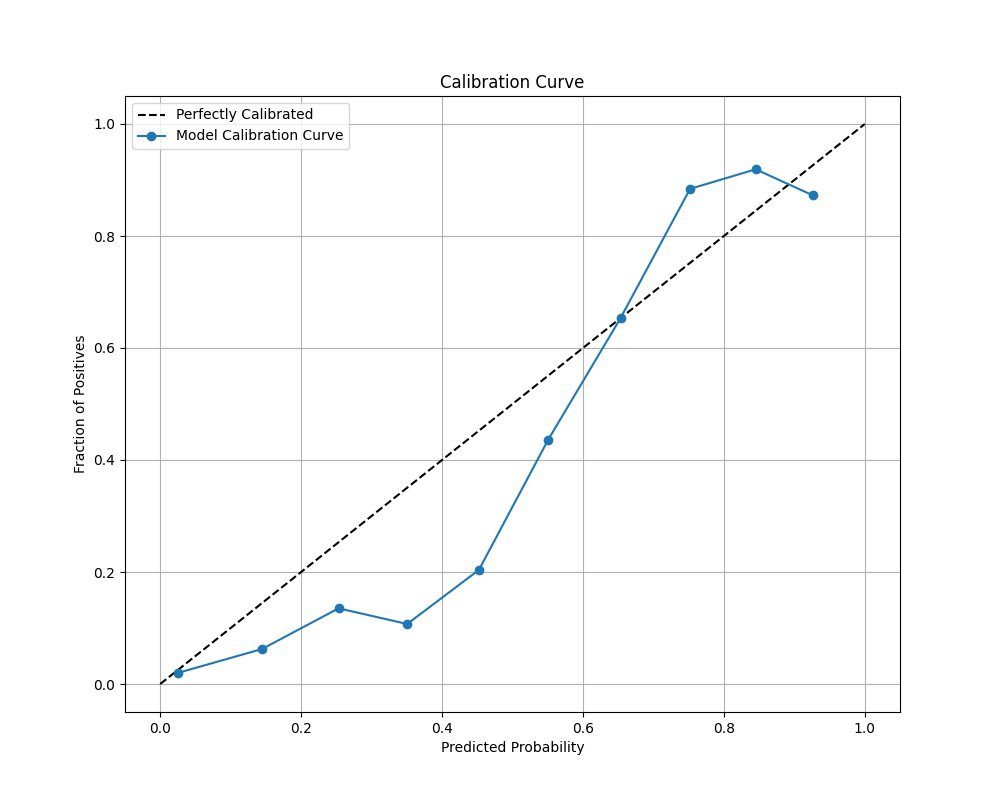

In [27]:
uq.model_calibration_plot(np.array(true_labels), np.array(mean_pred))

In [28]:
good_idx = [k for k in range(len(all_results)) if all_results[k]['true_label'] == all_results[k]['predicted_class']]
bad_idx = [k for k in range(len(all_results)) if all_results[k]['true_label'] != all_results[k]['predicted_class']]

In [29]:
stds = uq.ensembling_stds_computation(models_pred)
distances = uq.distance_to_gold_standard_computation(mean_ensembling_pred)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Stds', data=df, palette='muted')
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


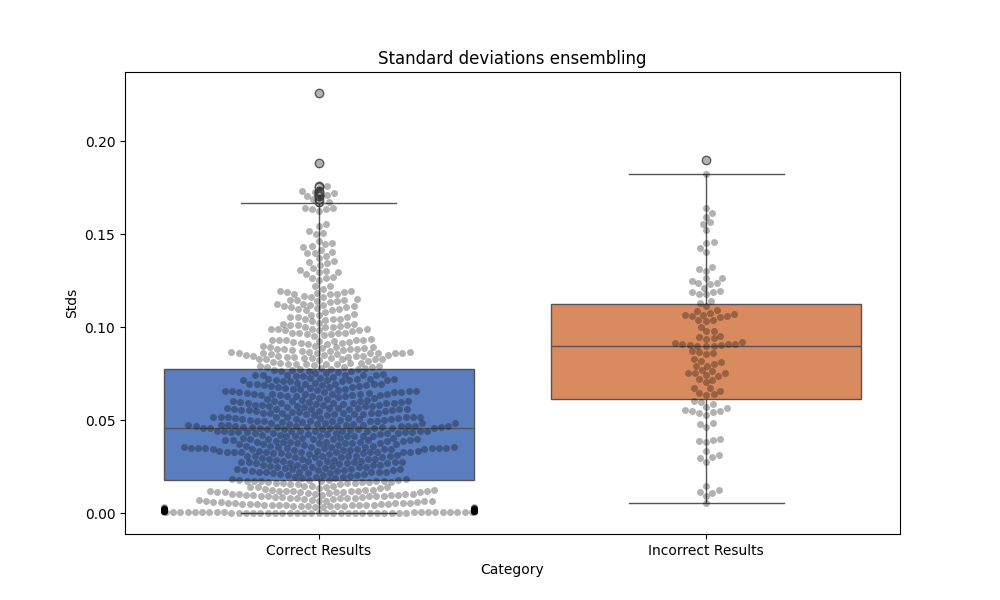

In [30]:
uq.ensembling_std_plot([stds[k] for k in good_idx], [stds[j] for j in bad_idx])

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Distance', data=df, palette='muted')
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


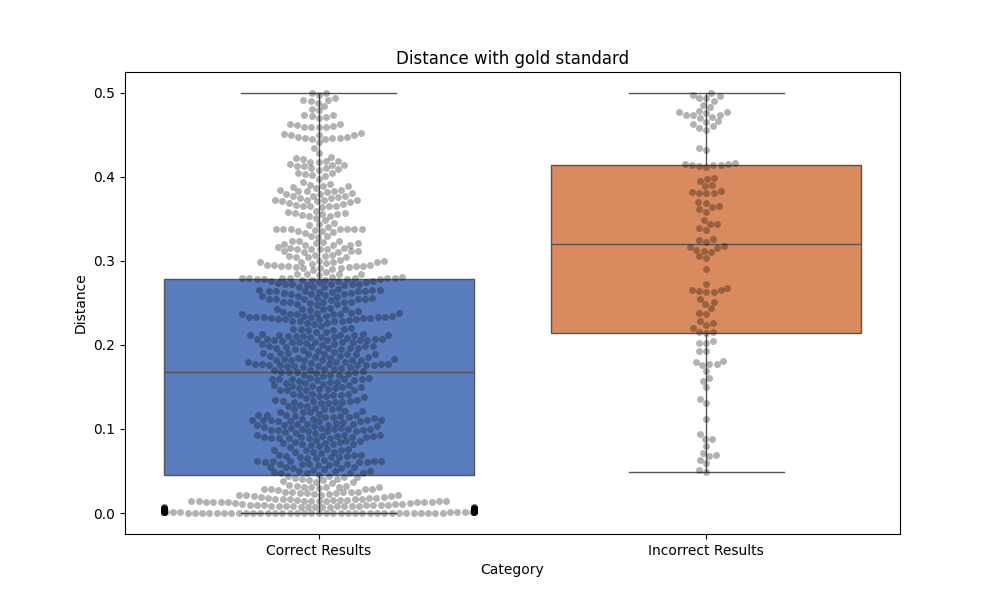

/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [31]:
uq.distance_to_gold_std_plot([distances[k] for k in good_idx], [distances[j] for j in bad_idx])

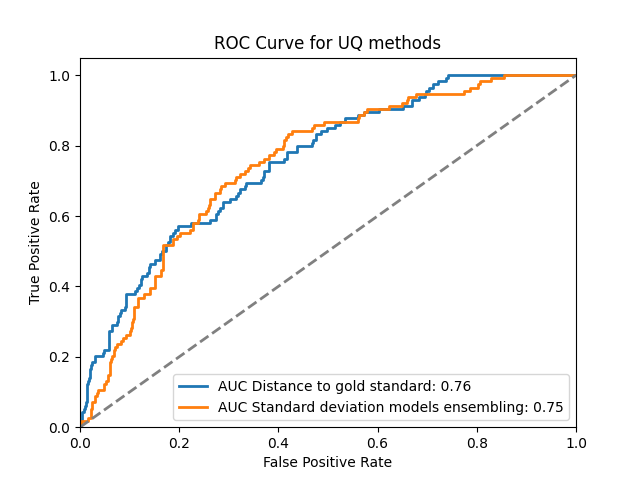

In [33]:
fpr_distance_to_gstd, tpr_distance_to_gstd, auc_distance_to_gstd = uq.roc_curve_UQ_method_computation([distances[k] for k in good_idx], [distances[j] for j in bad_idx])
fpr_std, tpr_std, auc_std = uq.roc_curve_UQ_method_computation([stds[k] for k in good_idx], [stds[j] for j in bad_idx])

uq.roc_curve_UQ_methods_plot(['Distance to gold standard', 'Standard deviation models ensembling'], [fpr_distance_to_gstd, fpr_std], [tpr_distance_to_gstd, tpr_std], [auc_distance_to_gstd, auc_std])

In [81]:
# Store results
all_results_amb = []
mean_pred_amb = []
true_labels_amb = []
models = [model.to(device) for model in models]
# Inference
with torch.no_grad():
    for batch in eval_data_amb:
        images = batch['image']
        labels = batch['shape']  # Assuming 'shape' is the label

        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred_amb.append(np.mean(pred_probs))
        true_labels_amb.append(labels.item())
        all_results_amb.append({
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs),
            'mean': np.mean(pred_probs)
        })

In [82]:
# Store results
all_results_amb_tr = []
mean_pred_amb_tr = []
true_labels_amb_tr = []
models = [model.to(device) for model in models]
# Inference
with torch.no_grad():
    for batch in tr_data_amb:
        images = batch['image']
        labels = batch['shape']  # Assuming 'shape' is the label

        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred_amb_tr.append(np.mean(pred_probs))
        true_labels_amb_tr.append(labels.item())
        all_results_amb_tr.append({
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs),
            'mean': np.mean(pred_probs)
        })

In [51]:
class AddBatchDimension:
    def __call__(self, image):
        # Ensure the image is a tensor and add batch dimension
        if isinstance(image, torch.Tensor):
            return image.unsqueeze(0)
        raise TypeError("Input should be a torch Tensor")

In [56]:
tta_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandAugment(3, 29),
        transforms.PILToTensor(),
        AddBatchDimension(),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=mean, std=std)
    ])

In [57]:
data_without_amb_TTA = axialcuts_dataset_eval.data[axialcuts_dataset_eval.data['Shape']!='Ambiguous']
data_without_amb_TTA = AxialCutsDataset(data_shape=data_without_amb_TTA, downsample=False)
eval_data_TTA = DataLoader(data_without_amb_TTA, num_workers=12)

In [60]:
ll_results = []
mean_pred = []
true_labels = []
models = [model.to(device) for model in models]
# Inference
with torch.no_grad():
    for batch in eval_data_TTA:
        tta_pred = uq.TTA(tta_transform, models[0], batch['image'], device)
        print(np.std(tta_pred))

0.0012900938
0.00068230584
0.0015093762
0.0012275901
0.0008637223
0.0004998686
0.0009844077
0.0015410708
0.0017690498
0.0014413384
0.0014972308
0.0009804897
0.0015517899
0.0014682842
0.00030822965
0.00072885095
0.00069721753
0.0012211392
0.00055742345
0.001225048
0.0011340535
0.0010848643
0.00095018983
0.000737556
0.0011381241
0.0011853697
0.00090873096
0.0011344998
0.0015423889
0.0007116705
0.00067036616
0.0013714129
0.0014903896
0.0008314057
0.0013749177
0.0009931653
0.00086297694
0.00088736066
0.0010289392
0.00078180025
0.0015475855
0.00091342774
0.0016855187
0.0004271575
0.0015515643
0.00087843416
0.0008786226
0.0010222327
0.0009016844
0.0012818483
0.001314511
0.00081035646
0.0008557848
0.00077860814
0.000808518
0.0012041517
0.0009754472
0.0012209
0.0005859527
0.0008048793
0.00091736036
0.000635366
0.00175864
0.0009777575
0.0011544928
0.0015484184
0.0010698078
0.0017723662
0.0022413938
0.0009037197
0.0012196616
0.0005702108
0.0010217741
0.0013925666
0.0010147754
0.0006515556
0.0014

In [59]:
tta_pred

[array([[0.685081]], dtype=float32),
 array([[0.68296045]], dtype=float32),
 array([[0.68469596]], dtype=float32),
 array([[0.6836021]], dtype=float32),
 array([[0.6848211]], dtype=float32),
 array([[0.6851471]], dtype=float32),
 array([[0.68570733]], dtype=float32),
 array([[0.68527883]], dtype=float32),
 array([[0.6854409]], dtype=float32),
 array([[0.68196195]], dtype=float32)]